In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pylab as pl
import matplotlib.pyplot as plt 
import time # We will use this to time our experiments for various observations

%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
class gridWorld(object):
    
    def __init__(self):
        super(gridWorld, self).__init__()
        self.start = 0
        self.goal = 0
        # Provide the setting of gridWorld rows and columns
        self.row = 7
        self.col = 10
        self.x_max = self.col - 1
        self.y_max = self.row - 1
        # Declare windy columns and their effect
        self.wind_1 = [3, 4, 5, 8]
        self.wind_2 = [6, 7]
        # Provide action list : Up/Down/Left/Right
        self.actions_list = ['N', 'E', 'S', 'W']
        
    def cell(self,pos):
        return pos[1] + self.col * pos[0]
    
    def setTerminal(self, startState, goalState):
        # startState and goalState are tuples
        self.start = self.cell(startState)
        self.goal = self.cell(goalState)
        
    def nextState(self, state, action):
        # The "state" parameter is an integer that represents position in grid
        x = state % self.col
        y = (state - x) / self.col
        # Now let's define and interpret actions
        del_x = 0
        del_y = 0
        if action == 'E':
            del_x = 1
        elif action == 'W':
            del_x = -1
        elif action == 'N':
            del_y = -1
        elif action == 'S':
            del_y = 1
        else:
            raise('Invalid action! Actions taken must be in: ',self.actions_list)
        # Now move to new position
        new_x = max(0, min(x + del_x, self.x_max))
        new_y = max(0, min(y + del_y, self.y_max))
        # When wind blows to a new state
        if new_x in self.wind_1:
            new_y = max(0, new_y - 1)
        if new_x in self.wind_2:
            new_y = max(0, new_y - 2)
        # now let's return these new state values
        return self.cell((new_y,new_x))
    
    def checkTerminal(self, state):
        return state == self.goal
    
    def rewardFunction(self, state_prime):
        # When it reaches goal state then reward is 0 else all actions should yield -1
        if state_prime == self.goal:
            return 0
        else:
            return -1
        
def trajectoryPath(world, traj):
    # Initialize gridworld
    world_map = np.zeros((world.row, world.col))
    for i,state in enumerate(traj):
        x = int(state % world.col)
        y = int((state - x) / world.col)
        world_map[y, x] = i + 1
    print(world_map)
    print("\n")

In [3]:
def gridWorld_SARSA(world, startState, goalState, alpha=0.1, gamma=1, epsilon=0.1):
    # Consider input parameters:
    # gamma = 1 as discounted factor
    # default values of alpha and epsilon considered, it will be changed for multiple analysis
    world.setTerminal(startState, goalState)
    # Initialize Q(s,a)
    q_table = {}
    for state in range(world.row * world.col):
        q_table[state] = {}
        for act in world.actions_list:
            q_table[state][act] = 0
    
    # function for greedy action
    def epsGreedy(episode, q_dict):
        def greedyAct(_q_dict):
            greedy_act = ''
            max_q = -1e10
            for act in world.actions_list:
                if _q_dict[act] > max_q:
                    greedy_act = act
                    max_q = _q_dict[act]
            return greedy_act
        
        m = len(world.actions_list)
        greedy_act = greedyAct(q_dict)
        p = []
        for act in world.actions_list:
            if act == greedy_act:
                p.append((epsilon * 1. / m) + 1 - epsilon)
            else:
                p.append(epsilon * 1. / m)
        choice = np.random.choice(world.actions_list,size = 1, p = p)
        return choice[0]
    
    ep = 1 # Episode number
    ep_max = 300 # number of max episodes
    step_ep_list = []
    step = 0
    while ep < ep_max:
        #print("Episode: ", ep)
        # Initialize state
        state = world.cell(startState)
        trajectory = [state]
        # Choose action from state
        act = epsGreedy(ep, q_table[state])
        while not world.checkTerminal(state):
            state_prime = world.nextState(state, act)
            reward = world.rewardFunction(state_prime)
            act_prime = epsGreedy(ep, q_table[state_prime])
            q_table[state][act] += alpha * (reward + gamma * q_table[state_prime][act_prime] - q_table[state][act])
            state = state_prime
            act = act_prime
            # Increase Step Counter
            step += 1
            # Store the index of the episode of this time step
            step_ep_list.append(ep)
            # Update the trajectory
            trajectory.append(state)
        
        if ep == (ep_max - 1):
            trajectoryPath(world, trajectory)
        # Increase the episode counter
        ep += 1
    
    start_time = time.time()
    plt.plot(step_ep_list)
    print("Time elapsed is (in Secs): ", time.time() - start_time)
    plt.title('WindyGridWorld_SARSA ', fontsize = 'large')
    plt.xlabel("Number of Steps taken")
    plt.ylabel("Number of Episodes")
    plt.show()

Plot for Option: ∈=0.1,α=0.1 

[[32. 31.  0.  0. 40. 41. 42. 43. 44. 45.]
 [35. 36. 13. 39.  0.  0.  0.  0.  0. 46.]
 [22. 37. 38.  0.  0.  0.  0.  0.  0. 47.]
 [ 1. 18.  0.  0.  0.  0.  0. 53.  0. 48.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 49.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 52. 50.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 51.]]


Time elapsed is (in Secs):  0.01695394515991211


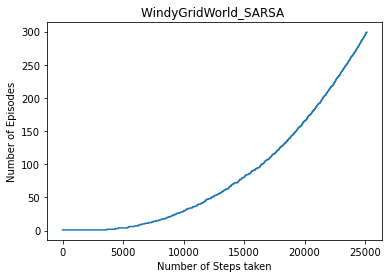

In [13]:
if __name__ == '__main__':
    startState = (3, 0)
    goalState = (3, 7)
    world = gridWorld()
    print("Plot for Option: ∈=0.1,α=0.1 \n")
    gridWorld_SARSA(world, startState, goalState, alpha=0.1, epsilon=0.1)

Plot for Option: ∈=0.1,α=0.2 

[[22.  0.  0.  0.  0. 34. 35. 36. 37. 38.]
 [23. 28. 15.  0. 33.  0.  0.  0.  0. 39.]
 [24. 29. 26. 32.  0.  0.  0.  0.  0. 40.]
 [ 5. 30. 31.  0.  0.  0.  0. 46.  0. 41.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 42.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 45. 43.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 44.]]


Time elapsed is (in Secs):  0.01695537567138672


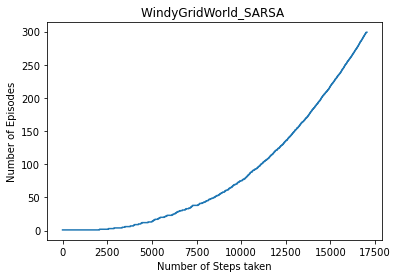

In [14]:
if __name__ == '__main__':
    startState = (3, 0)
    goalState = (3, 7)
    world = gridWorld()
    print("Plot for Option: ∈=0.1,α=0.2 \n")
    gridWorld_SARSA(world, startState, goalState, alpha=0.2, epsilon=0.1)

Plot for Option: ∈=0.1,α=0.5 

[[ 0.  0.  0.  0.  0.  0. 11. 12. 13. 14.]
 [ 0.  0.  0.  0.  0. 10.  0.  0.  0. 15.]
 [ 0.  0.  0.  0.  9.  0.  0.  0.  0. 16.]
 [ 1.  0.  0.  0.  0.  0.  0. 22.  0. 17.]
 [ 2.  0.  0.  0.  8.  0.  0.  0.  0. 18.]
 [ 3.  0.  0.  7.  0.  0.  0.  0. 21. 19.]
 [ 4.  5.  6.  0.  0.  0.  0.  0.  0. 20.]]


Time elapsed is (in Secs):  0.016954898834228516


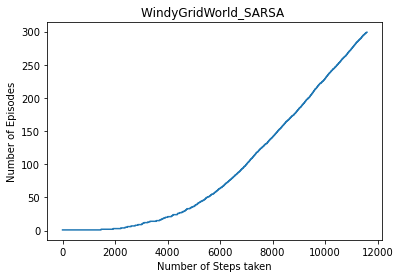

In [15]:
if __name__ == '__main__':
    startState = (3, 0)
    goalState = (3, 7)
    world = gridWorld()
    print("Plot for Option: ∈=0.1,α=0.5 \n")
    gridWorld_SARSA(world, startState, goalState, alpha=0.5, epsilon=0.1)

Plot for Option: ∈=0.2,α=0.1 

[[ 0.  0.  0. 23. 24. 25. 26. 27. 28. 29.]
 [ 0.  0.  0. 18.  0.  0.  0.  0.  0. 31.]
 [ 0. 15. 16. 13.  0.  0.  0.  0.  0. 32.]
 [ 1.  0.  0.  0. 12.  0.  0. 38.  0. 33.]
 [ 2.  0.  0. 10.  0.  0.  0.  0.  0. 34.]
 [ 3.  4.  9.  0.  0.  0.  0.  0. 37. 35.]
 [ 0.  7.  8.  0.  0.  0.  0.  0.  0. 36.]]


Time elapsed is (in Secs):  0.018949270248413086


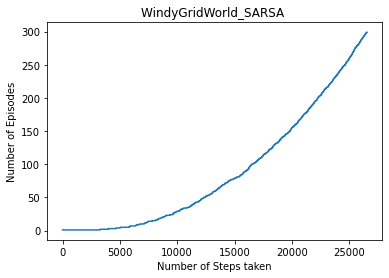

In [16]:
if __name__ == '__main__':
    startState = (3, 0)
    goalState = (3, 7)
    world = gridWorld()
    print("Plot for Option: ∈=0.2,α=0.1 \n")
    gridWorld_SARSA(world, startState, goalState, alpha=0.1, epsilon=0.2)

Plot for Option: ∈=0.2,α=0.2 

[[ 0.  0.  0.  0.  7.  8.  9. 10. 11. 12.]
 [ 0.  0.  0.  6.  0.  0.  0.  0.  0. 13.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 14.]
 [ 1.  2.  3.  5.  0.  0.  0. 20.  0. 15.]
 [ 0.  0.  4.  0.  0.  0.  0.  0.  0. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 19. 17.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 18.]]


Time elapsed is (in Secs):  0.015956401824951172


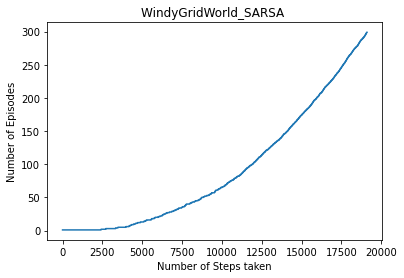

In [17]:
if __name__ == '__main__':
    startState = (3, 0)
    goalState = (3, 7)
    world = gridWorld()
    print("Plot for Option: ∈=0.2,α=0.2 \n")
    gridWorld_SARSA(world, startState, goalState, alpha=0.2, epsilon=0.2)

Plot for Option: ∈=0.2,α=0.5 

[[ 0.  0.  0.  6.  7.  8.  9. 10. 11. 15.]
 [ 0.  0.  5.  0.  0.  0.  0.  0.  0. 16.]
 [ 2.  3.  4.  0.  0.  0.  0.  0.  0. 17.]
 [ 1.  0.  0.  0.  0.  0.  0. 26.  0. 18.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 19.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 25. 23.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 24.]]


Time elapsed is (in Secs):  0.018949508666992188


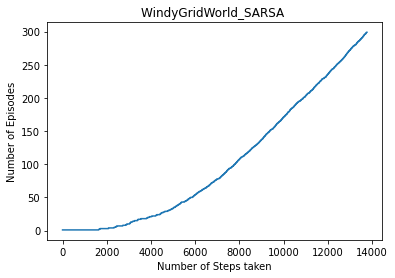

In [18]:
if __name__ == '__main__':
    startState = (3, 0)
    goalState = (3, 7)
    world = gridWorld()
    print("Plot for Option: ∈=0.2,α=0.5 \n")
    gridWorld_SARSA(world, startState, goalState, alpha=0.5, epsilon=0.2)

In [7]:
def gridWorld_QLearning(world, startState, goalState, alpha, gamma=1, ep_max=300, eps=0.1):
    world.setTerminal(startState, goalState) 
    # Initialize Q(s, a)
    q_dict = {}
    for state in range(world.row * world.col):
        q_dict[state] = {}
        for act in world.actions_list:
            if world.checkTerminal(state):
                q_dict[state][act] = 0
            else:
                q_dict[state][act] = np.random.rand()

    def greedyAct(_q_dict):
        greedy_act = ''
        max_q = -1e10
        for act in world.actions_list:
            if _q_dict[act] > max_q:
                greedy_act = act
                max_q = _q_dict[act]
        return greedy_act

    def epsGreedy(episode, q_dict):
        m = len(world.actions_list)
        greedy_act = greedyAct(q_dict)
        p = []
        for act in world.actions_list:
            if act == greedy_act:
                p.append((eps * 1. / m) + 1 - eps)
            else:
                p.append(eps * 1. / m)
        choice = np.random.choice(world.actions_list, size=1, p=p)
        return choice[0]

    ep_wrt_step = []
    trajectory = []
    for ep in range(1, ep_max + 1):
        s = world.start
        trajectory = []
        while not world.checkTerminal(s):
            # Choose act according to behaviour policy
            act = epsGreedy(ep, q_dict[s])
            # take act, observe s_prime & reward
            s_prime = world.nextState(s, act)
            reward = world.rewardFunction(s_prime)

            # choose act_prime according to target policy
            act_prime = greedyAct(q_dict[s_prime])
            # Update Q(s, a)
            q_dict[s][act] += alpha * (reward + gamma * q_dict[s_prime][act_prime] - q_dict[s][act])

            # store trajectory
            trajectory.append(s)

            # update current state
            s = s_prime
            # store the index of this episode for plot
            ep_wrt_step.append(ep)
        trajectory.append(world.goal)
    return trajectory, ep_wrt_step

Time elapsed:  0.9833695888519287
[[ 0.  0.  0.  0.  0.  0. 11. 12. 13. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 15.]
 [ 0.  0.  0.  0.  0. 10.  0.  0.  0. 16.]
 [ 1.  0.  0.  0.  9.  0.  0. 22.  0. 17.]
 [ 2.  0.  0.  7.  0.  0.  0.  0.  0. 18.]
 [ 4.  5.  6.  0.  0.  0.  0.  0. 21. 19.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 20.]]




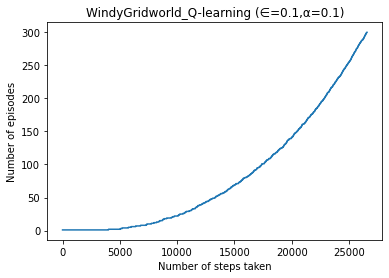

In [24]:
if __name__ == '__main__':
    _start = (3, 0)
    _goal = (3, 7)
    world = gridWorld()
    start_time = time.time()
    trajectory, ep_wrt_step = gridWorld_QLearning(world, startState, goalState, alpha=0.1,gamma=0.9,ep_max=300, eps=0.1)
    print("Time elapsed: ", time.time() - start_time)
    trajectoryPath(world, trajectory)
    pl.figure(1)
    pl.plot(ep_wrt_step)
    plt.title('WindyGridworld_Q-learning (∈=0.1,α=0.1)', fontsize = 'large')
    pl.xlabel("Number of steps taken")
    pl.ylabel("Number of episodes")
    pl.show()

Time elapsed:  0.6881582736968994
[[ 0.  0.  0.  0.  0.  0. 22. 23. 24. 25.]
 [ 0.  0.  0.  0.  0.  0. 21.  0.  0. 26.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 27.]
 [ 1.  0.  0.  0.  0. 20.  0. 33.  0. 28.]
 [ 4.  5.  0.  0. 19.  0.  0.  0.  0. 29.]
 [11.  6.  0. 17.  0.  0.  0.  0. 32. 30.]
 [12. 15. 16.  0.  0.  0.  0.  0.  0. 31.]]




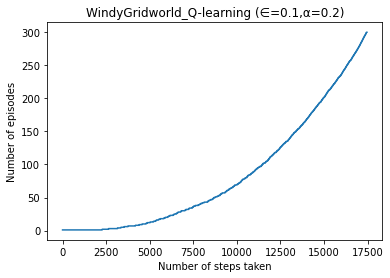

In [26]:
if __name__ == '__main__':
    _start = (3, 0)
    _goal = (3, 7)
    world = gridWorld()
    start_time = time.time()
    trajectory, ep_wrt_step = gridWorld_QLearning(world, startState, goalState, alpha=0.2,gamma=0.9,ep_max=300, eps=0.1)
    print("Time elapsed: ", time.time() - start_time)
    trajectoryPath(world, trajectory)
    pl.figure(1)
    pl.plot(ep_wrt_step)
    plt.title('WindyGridworld_Q-learning (∈=0.1,α=0.2)', fontsize = 'large')
    pl.xlabel("Number of steps taken")
    pl.ylabel("Number of episodes")
    pl.show()

Time elapsed:  0.43323659896850586
[[ 0.  0.  0.  0.  0.  6.  7.  8. 11. 12.]
 [ 0.  0.  0.  0.  5.  0.  0.  0. 15. 16.]
 [ 0.  0.  0.  4.  0.  0.  0.  0. 19. 20.]
 [ 1.  2.  3.  0.  0.  0.  0. 26.  0. 21.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 22.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 25. 23.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 24.]]




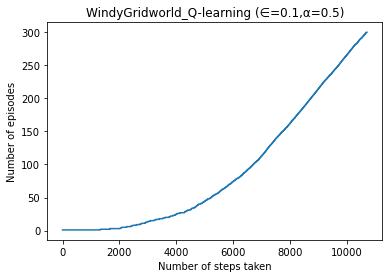

In [28]:
if __name__ == '__main__':
    _start = (3, 0)
    _goal = (3, 7)
    world = gridWorld()
    start_time = time.time()
    trajectory, ep_wrt_step = gridWorld_QLearning(world, startState, goalState, alpha=0.5,gamma=0.9,ep_max=300, eps=0.1)
    print("Time elapsed: ", time.time() - start_time)
    trajectoryPath(world, trajectory)
    pl.figure(1)
    pl.plot(ep_wrt_step)
    plt.title('WindyGridworld_Q-learning (∈=0.1,α=0.5)', fontsize = 'large')
    pl.xlabel("Number of steps taken")
    pl.ylabel("Number of episodes")
    pl.show()